In [2]:
import tensorflow as tf 

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import PIL
import time
import glob
import imageio

In [3]:
'''
    FIX:
        Mode collapse is still a huge problem here. Using MSE as the loss function makes it happen less often, but
        makes the quality of the generated samples not as crisp as Binary Crossentropy
'''

'\n    FIX:\n        Mode collapse is still a huge problem here. Using MSE as the loss function makes it happen less often, but\n        makes the quality of the generated samples not as crisp as Binary Crossentropy\n'

In [5]:
mnist = tf.keras.datasets.fashion_mnist
(train_images, _), (_, _) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)

4423680/4422102 [==============================] - 5s 1us/step


In [6]:
# Batch and shuffle the data
EPOCHS = 50
BUFFER_SIZE = 6000
BATCH_SIZE = 60
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(60)
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [7]:
def build_gen_model():
    model = tf.keras.Sequential([
                               tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100, )),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.LeakyReLU(),

                               tf.keras.layers.Reshape((7, 7, 256)),

                               tf.keras.layers.Conv2DTranspose(128, (5, 5), padding='same', use_bias=False),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.LeakyReLU(),

                               tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
                               tf.keras.layers.BatchNormalization(),
                               tf.keras.layers.LeakyReLU(),

                               tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
  ])
    assert model.output_shape == (None, 28, 28, 1)
    return model

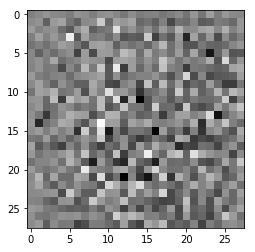

In [8]:
gen = build_gen_model()

im = gen(tf.random.normal([1,100]), training=False)
plt.imshow(np.squeeze(im), cmap='gray')

In [9]:
def build_disc_model():
    model = tf.keras.Sequential([
                               tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape = (28, 28, 1)),
                               tf.keras.layers.LeakyReLU(),
                               tf.keras.layers.Dropout(0.3),

                               tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
                               tf.keras.layers.LeakyReLU(),
                               tf.keras.layers.Dropout(0.3),

                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)

                               ])
    return model

In [10]:
disc = build_disc_model()
print(np.squeeze(disc(im, training=False)))


0.49988034


In [22]:
loss = tf.keras.losses.binary_crossentropy
#loss = tf.keras.losses.mse

def discriminator_loss(real_output, fake_output):
    real_loss = loss(real_output, tf.ones_like(real_output))
    fake_loss = loss(fake_output, tf.zeros_like(fake_output))
    return fake_loss + real_loss


In [23]:
def generator_loss(fake_output):
    return loss(tf.ones_like(fake_output), fake_output)

In [24]:
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [26]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    filename = 'image_at_epoch_'+str(epoch)+'.png'
    plt.savefig(filename)
    plt.show()

In [27]:
@tf.function
def train_step(images):
    noise = tf.random.normal([len(images), noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen(noise, training=True)

        real_output = disc(images, training=True)
        fake_output = disc(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gen_gradient = gen_tape.gradient(gen_loss, gen.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, disc.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradient, gen.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradient, disc.trainable_variables))


In [28]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        display.clear_output(wait=True)
        generate_and_save_images(gen,
                                 epoch + 1,
                                 seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(gen,
                           epochs,
                           seed)




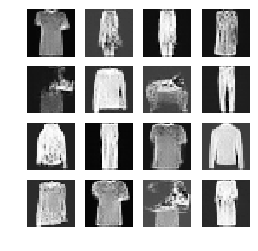

In [29]:
train(train_dataset, EPOCHS)

In [30]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_'+str(epoch_no)+'.png')

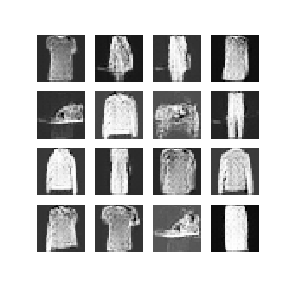

In [31]:
display_image(1)

In [32]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)